# Allen-Cahn 3D
Goal: solve the Allen-Cahn PDE given as

$
\begin{align}
& u_t - \frac{u_{xx}}{10000} + 5u^3 - 5u = 0, \\
& u(x,0)=x^2cos(\pi x), \\
& u(t,-1)=u(t,1), \\
& u_x(t,-1)=u_x(t,1)
\end{align}
$

where $x \in [-1,1]\text{ and }t \in [0,1]$

In [1]:
from dolfin import *
from time import perf_counter
import scipy.io
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import matplotlib.pyplot as plt
%matplotlib notebook

output = "solutions/allen-cahn-3d/"

In [2]:
## parameters
#####################################

(nx, ny, nz) = (20, 20, 20)     # mesh points
dt           = 10e-3            # time step
(x0, xf)     = (0.0, 1.0)       # x-boundaries
(y0, yf)     = (0.0, 1.0)       # y-boundaries
(z0, zf)     = (0.0, 1.0)       # z-boundaries

# Form compiler options
parameters["form_compiler"]["optimize"]     = True
parameters["form_compiler"]["cpp_optimize"] = True

In [3]:
# Class for interfacing with the Newton solver
class AllenCahnEquation(NonlinearProblem):
    def __init__(self, a, L):
        NonlinearProblem.__init__(self)
        self.L = L
        self.a = a
    def F(self, b, x):
        assemble(self.L, tensor=b)
    def J(self, A, x):
        assemble(self.a, tensor=A)

In [4]:
# Sub domain for Periodic boundary condition
class PeriodicBoundary(SubDomain):

    # Left, bottom, and front faces are the target domains
    def inside(self, x, on_boundary):
        return (near(x[0], x0) or near(x[1], y0) or near(x[2], z0)) and on_boundary

    # Map:
    #  + right face to left face
    #  + top face to bottom face
    #  + back face to front face
    def map(self, x, y):
        y[0] = x[0] - (xf - x0)
        y[1] = x[1] - (yf - y0)
        y[2] = x[2] - (zf - z0)

In [5]:
# return random uniform distribution over [-scale/2, scale/2]
class InitialConditions(UserExpression):
    def __init__(self, **kwargs):
        np.random.seed(2 + MPI.rank(MPI.comm_world))
        super().__init__(**kwargs)
        self.scale = 1.0
    def eval(self, values, x):
        values[0] = self.scale * np.random.rand() - self.scale/2
    def value_shape(self):
        return()

In [6]:
# formulate problem
#####################################

# create periodic boundary condition
pbc = PeriodicBoundary()

# setup mesh
mesh = BoxMesh(Point(x0, y0, z0), Point(xf, yf, zf), nx, ny, nz)
V = FunctionSpace(mesh, "CG", 1, constrained_domain=pbc)

# define test & trial functions
du = TrialFunction(V)
v = TestFunction(V)

# define functions
u = Function(V)
u0 = Function(V)

# initial conditions
u_init = InitialConditions(degree=0)
u.interpolate(u_init)
u0.interpolate(u_init)

gamma1 = 0.0001
gamma2 = 4 # {test 1 (easiest):4 (hardest)}

F = u*v*dx - u0*v*dx +                    \
    dt*gamma1*dot(grad(u), grad(v))*dx +  \
    dt*gamma2*(u**3 - u)*v*dx

J = derivative(F, u, du)

In [7]:
# Create nonlinear problem and Newton solver
problem = AllenCahnEquation(J, F)
solver = NewtonSolver()

file = File(output + 'data/ac3.pvd', "compressed")

In [8]:
# map mesh vertices to solution DOFs
#####################################

dof_coordinates = V.tabulate_dof_coordinates()
u_dofs = V.dofmap().dofs()
dofs  = np.squeeze(dof_coordinates[u_dofs])
ind = np.lexsort((dofs[:,0], dofs[:,1], dofs[:,2]))

0 / 100
10 / 100
20 / 100
30 / 100
40 / 100
50 / 100
60 / 100
70 / 100
80 / 100
90 / 100

Took 307.84 seconds.


<IPython.core.display.Javascript object>


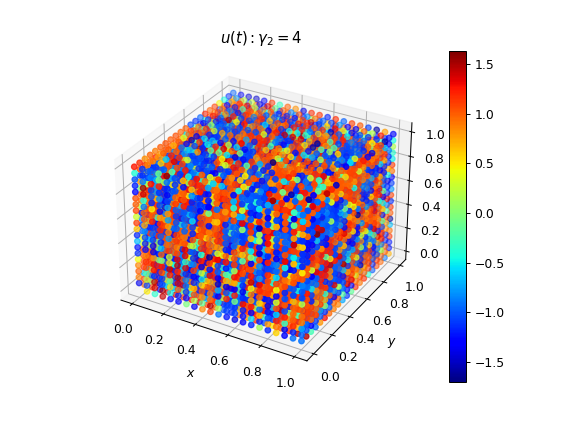

In [9]:
# time stepping
#####################################

(t, T) = (0.0, 1.0)
(n, N) = (0, int(round(T/dt, 0)))

sol = {}
sol['x'] = dofs[ind]
sol['t'] = np.zeros((N,1))
sol['u'] = np.zeros((len(sol['x']), len(sol['t'])))

t0 = perf_counter()
while n < N:
    
    # compute current solution
    solver.solve(problem, u.vector())
    
    # save output
    sol['t'][n] = t
    sol['u'][:,n] = u.vector()[u_dofs][ind]
    file << (u, t)
    
    # update previous solution
    u0.vector()[:] = u.vector()        
    
    # print progress
    if n % round(N/10,0) == 0:
        print(f"{n} / {N}")
        
    # increment time
    t += dt
    n += 1
        

tf = perf_counter()
print(f"\nTook {tf-t0:.2f} seconds.")

fig = plt.figure(1)
ax = fig.add_subplot(111, projection='3d')
h = ax.scatter(dofs[:,0], dofs[:,1], dofs[:,2], c=u.vector()[:], cmap='jet')
plt.title(f"$u(t):\gamma_2={gamma2}$")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_zlabel("$z$")
fig.colorbar(h, ax=ax)
plt.show()

In [10]:
def snapshot(i):
    plt.cla()
    ax.scatter(dofs[:,0], dofs[:,1], dofs[:,2], s=30, c=sol['u'][:,i], cmap='jet')
    plt.rc('xtick',labelsize=12)
    plt.rc('ytick',labelsize=12)
    ax.set_xlabel('$x$',fontsize='x-large')
    ax.set_ylabel("$y$",fontsize='x-large')
    ax.set_zlabel("$z$",fontsize='x-large')
    plt.title(f'Allen-Cahn: $\gamma_2={gamma2}$')
    ax.view_init(30, 30)
    plt.draw()

<IPython.core.display.Javascript object>


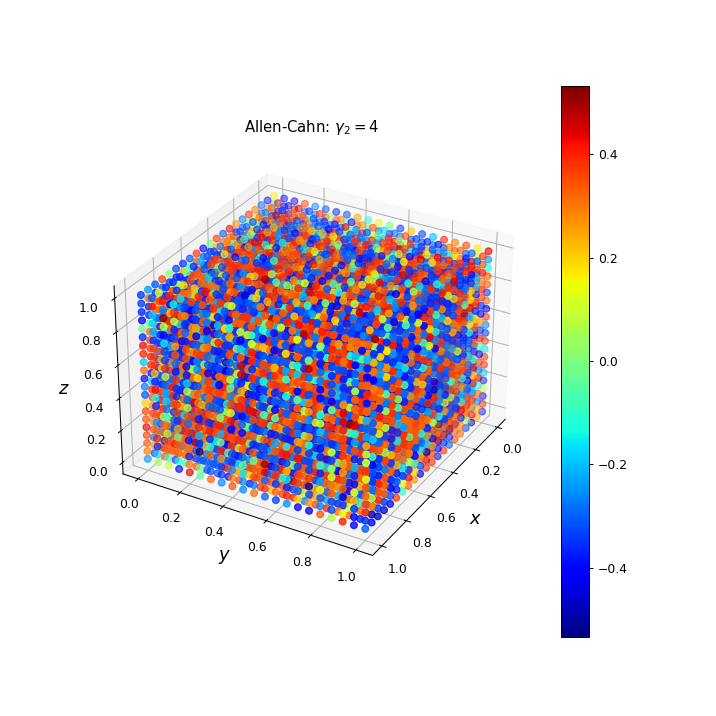

In [11]:
fig = plt.figure(figsize=(8,8), dpi=100)
ax = fig.add_subplot(111, projection='3d')
h = ax.scatter(dofs[:,0], dofs[:,1], dofs[:,2], s=100, c=sol['u'][:,1], cmap='jet')
fig.colorbar(h, ax=ax)
snapshot(N-1)

<IPython.core.display.Javascript object>


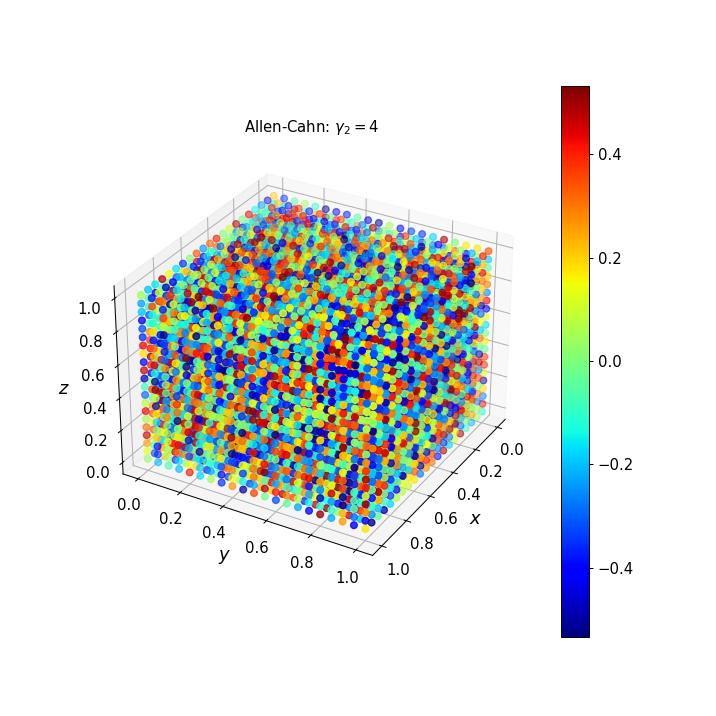

In [12]:
fig = plt.figure(figsize=(8,8), dpi=100)
ax = fig.add_subplot(111, projection='3d')
h = ax.scatter(dofs[:,0], dofs[:,1], dofs[:,2], c=sol['u'][:,1], cmap='jet')
fig.colorbar(h, ax=ax)

anim = animation.FuncAnimation(fig,snapshot,frames=N)
anim.save(output + f'allen-cahn-3d_{gamma2}.mp4',fps=N/10)